# Using a Deep Q-Network

## Retrieving Data

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np

In [19]:
key = 'L49TNJ1SKAPIG4BA'

### Loading price history data

In [20]:
ts = TimeSeries(key, output_format = 'pandas')
data, meta = ts.get_daily('AAPL', outputsize = 'full')
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data.columns = columns
data = data.sort_index(ascending=True)
print(data)


               Open    High       Low   Close      Volume
date                                                     
1999-11-01   80.000   80.69   77.3700   77.62   2487300.0
1999-11-02   78.000   81.69   77.3100   80.25   3564600.0
1999-11-03   81.620   83.25   81.0000   81.50   2932700.0
1999-11-04   82.060   85.37   80.6200   83.62   3384700.0
1999-11-05   84.620   88.37   84.0000   88.31   3721500.0
...             ...     ...       ...     ...         ...
2025-07-02  208.910  213.34  208.1400  212.44  67941811.0
2025-07-03  212.145  214.65  211.8101  213.55  34955836.0
2025-07-07  212.680  216.23  208.8000  209.95  50228984.0
2025-07-08  210.100  211.43  208.4500  210.01  42848928.0
2025-07-09  209.530  211.33  207.2200  211.14  48749367.0

[6460 rows x 5 columns]


### Loading technical indicators

In [21]:
data['Change Percentage'] = data['Close'].pct_change() * 100
data['Force Index'] = data['Close'].diff() * data['Volume']
    
typical_price = (data['High'] + data['Low'] + data['Close']) / 3
raw_money_flow = typical_price * data['Volume']
money_flow_direction = typical_price.diff()
positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
with np.errstate(divide='ignore', invalid='ignore'):
    money_ratio = positive_mf / negative_mf
    data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
    data['Money Flow Index'].replace([np.inf], 100, inplace=True)

data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    
   
data['Standard Deviation'] = data['Close'].rolling(window=20).std()
print(data)

               Open    High       Low   Close      Volume  Change Percentage  \
date                                                                           
1999-11-01   80.000   80.69   77.3700   77.62   2487300.0                NaN   
1999-11-02   78.000   81.69   77.3100   80.25   3564600.0           3.388302   
1999-11-03   81.620   83.25   81.0000   81.50   2932700.0           1.557632   
1999-11-04   82.060   85.37   80.6200   83.62   3384700.0           2.601227   
1999-11-05   84.620   88.37   84.0000   88.31   3721500.0           5.608706   
...             ...     ...       ...     ...         ...                ...   
2025-07-02  208.910  213.34  208.1400  212.44  67941811.0           2.223078   
2025-07-03  212.145  214.65  211.8101  213.55  34955836.0           0.522500   
2025-07-07  212.680  216.23  208.8000  209.95  50228984.0          -1.685788   
2025-07-08  210.100  211.43  208.4500  210.01  42848928.0           0.028578   
2025-07-09  209.530  211.33  207.2200  2

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_6269/118303788.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)


In [22]:
print(data)

               Open    High       Low   Close      Volume  Change Percentage  \
date                                                                           
1999-11-01   80.000   80.69   77.3700   77.62   2487300.0                NaN   
1999-11-02   78.000   81.69   77.3100   80.25   3564600.0           3.388302   
1999-11-03   81.620   83.25   81.0000   81.50   2932700.0           1.557632   
1999-11-04   82.060   85.37   80.6200   83.62   3384700.0           2.601227   
1999-11-05   84.620   88.37   84.0000   88.31   3721500.0           5.608706   
...             ...     ...       ...     ...         ...                ...   
2025-07-02  208.910  213.34  208.1400  212.44  67941811.0           2.223078   
2025-07-03  212.145  214.65  211.8101  213.55  34955836.0           0.522500   
2025-07-07  212.680  216.23  208.8000  209.95  50228984.0          -1.685788   
2025-07-08  210.100  211.43  208.4500  210.01  42848928.0           0.028578   
2025-07-09  209.530  211.33  207.2200  2

In [23]:
ti = TechIndicators(key, output_format = 'pandas')
roc, meta = ti.get_roc('AAPL')
sma, meta = ti.get_sma('AAPL')

### Seperating test and train data

In [24]:
train_data = data.loc['2012-02-01' : '2022-04-06']
test_data = data.loc['2022-04-07' : '2025-01-01']
print(train_data)

              Open    High      Low   Close       Volume  Change Percentage  \
date                                                                          
2012-02-01  458.41  458.99  455.550  456.19    9644500.0          -0.063530   
2012-02-02  455.90  457.17  453.980  455.12    6671300.0          -0.234551   
2012-02-03  457.30  460.00  455.560  459.68   10235700.0           1.001934   
2012-02-06  458.38  464.98  458.201  463.97    8907600.0           0.933258   
2012-02-07  465.25  469.75  464.581  468.83   11293700.0           1.047482   
...            ...     ...      ...     ...          ...                ...   
2022-03-31  177.84  178.03  174.400  174.61  103049285.0          -1.777578   
2022-04-01  174.03  174.88  171.940  174.31   78751328.0          -0.171811   
2022-04-04  174.57  178.49  174.440  178.44   76545983.0           2.369342   
2022-04-05  177.50  178.30  174.415  175.06   70902999.0          -1.894194   
2022-04-06  172.36  173.63  170.130  171.83   890587

In [25]:
roc = roc.sort_index()
train_roc = roc.loc['2012-02-01' : '2022-04-06']
test_roc = roc.loc['2022-04-07' : '2025-01-01']

Creating close price dataframe

In [56]:
train_close = train_data['Close']
test_close = test_data['Close']
print(train_close)

date
2012-02-01    456.19
2012-02-02    455.12
2012-02-03    459.68
2012-02-06    463.97
2012-02-07    468.83
               ...  
2022-03-31    174.61
2022-04-01    174.31
2022-04-04    178.44
2022-04-05    175.06
2022-04-06    171.83
Name: Close, Length: 2563, dtype: float64


### Normalising data

In [27]:
from sklearn.preprocessing import MinMaxScaler
state_features = pd.DataFrame({
    'ROC': train_roc['ROC'],
    'Volume': train_data['Volume'],
    'Change Percentage': train_data['Change Percentage'],
    'Force Index': train_data['Force Index'],
    'Money Flow Index': train_data['Money Flow Index'],
    'Price-Volume': train_data['Price-Volume'],
    'Standard Deviation': train_data['Standard Deviation']
})
scaler = MinMaxScaler()
scaled_features_array = scaler.fit_transform(state_features)

scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)
print(scaled_data.head())

                 ROC    Volume  Change Percentage  Force Index  \
date                                                             
2012-02-01  0.615023  0.012051           0.876426     0.956398   
2012-02-02  0.601129  0.002956           0.874671     0.956348   
2012-02-03  0.599206  0.013860           0.887357     0.956970   
2012-02-06  0.597216  0.009797           0.886653     0.956872   
2012-02-07  0.618859  0.017096           0.887825     0.957065   

            Money Flow Index  Price-Volume  Standard Deviation  
date                                                            
2012-02-01          0.691368      0.969408            0.047016  
2012-02-02          0.692855      0.969348            0.048360  
2012-02-03          0.745374      0.969740            0.050991  
2012-02-06          0.747046      0.970058            0.054609  
2012-02-07          0.750997      0.970510            0.058391  


In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(scaled_data)
print(X_train_pca)

[[ 0.33176149  0.15475271  0.02465765  0.04319038]
 [ 0.33386716  0.14867113  0.02014181  0.03240516]
 [ 0.33771627  0.1916602   0.01968086  0.00166646]
 ...
 [-0.44407229  0.3781103  -0.01010081 -0.01163896]
 [-0.45361284  0.31345248 -0.0102224   0.01455844]
 [-0.49104078  0.20325013 -0.0077262  -0.03263337]]


In [29]:
test_features = pd.DataFrame({
    'ROC': test_roc['ROC'],
    'Volume': test_data['Volume'],
    'Change Percentage': test_data['Change Percentage'],
    'Force Index': test_data['Force Index'],
    'Money Flow Index': test_data['Money Flow Index'],
    'Price-Volume': test_data['Price-Volume'],
    'Standard Deviation': test_data['Standard Deviation']
})


scaled_test_features_array = scaler.transform(test_features)
scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

In [46]:
X_test_pca = pca.transform(scaled_test_data)
print(X_test_pca)

[[-4.87696699e-01  1.61464754e-01 -3.39644495e-04  5.93243367e-02]
 [-4.98382326e-01  1.12095603e-01  8.77690937e-03  1.15506307e-01]
 [-5.09905112e-01  5.66429201e-02  7.79949303e-03  1.55549739e-01]
 ...
 [-3.34520918e-01  2.84249205e-01 -4.55687905e-02 -6.24236099e-03]
 [-3.40232346e-01  2.11343724e-01 -5.65040659e-02 -3.54670487e-03]
 [-3.54470880e-01  1.44567909e-01 -5.50009885e-02  4.28006853e-03]]


## Creating Deep Q Network

### Setting up environment

In [63]:
class environment:

    def __init__(self, price_data, state_data):
        self.data = price_data
        self.scaled_state_data = state_data
        self.roc = roc
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []

    def step(self, action):

        
        trade = [] 
        if self.index < len(self.data) - 7:
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
                
            
            total = self.get_net_worth()
            holding = (self.num_shares * data.iloc[self.index]) / total
            trade.append(total)
            trade.append(holding)
            trade.append(action)
            self.action_history.append(action)
            sold_bought = action - holding
            if action > holding:
                to_buy = (action - holding) * total
                new_balance = self.balance - to_buy
                if new_balance >= 0:
                    
                    new_shares = to_buy / self.data.iloc[self.index]
                    self.balance -= to_buy
                    self.num_shares += new_shares
            elif action < holding:
                to_sell = (holding - action) * total
                shares_to_sell = to_sell / data.iloc[self.index]
                new_num_shares = self.num_shares - shares_to_sell
                if new_num_shares >= 0:
                    self.num_shares = new_num_shares
                    self.balance += to_sell
            
            annual_rate = 0.054
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.balance = self.balance * (1+ daily_rate)
            
            
                
           
                
            
            trade.append(self.num_shares)
            trade.append(self.balance)
            
            trade.append(self.data.iloc[self.index])
            self.index += 1
            
            new_net_worth = self.get_net_worth()
            self.balance_history.append(old_net_worth)

            # The reward is the change in value
            reward = new_net_worth - old_net_worth
            
            self.trades.append(trade)
            self.total_reward += reward
            self.rewards.append(self.total_reward)
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.trades = []
    
    def get_net_worth(self):
        
        total = self.balance + (self.num_shares * self.data.iloc[self.index])
        return total
        
    def get_state(self):
        state = self.scaled_state_data[self.index].tolist()
        return state


### Training the model

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Create the Stock Environment
env = environment(train_close, X_train_pca)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 50
ACTIONS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Initialize Q-networks
input_dim = 4
output_dim = 11
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, len(ACTIONS) - 1)  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()
        

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
 
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
steps_done = 0

for episode in range(episodes):
    state = env.get_state()
    done = False
    i = 0
    for i in range(len(train_data) - 1):
        # Select action
        action_index = select_action(state, epsilon)
       
        action = ACTIONS[action_index]
        reward, done = env.step(action)
        
        next_state = env.get_state()
        # Store transition in memory
        memory.append((state, action_index, reward, next_state))
        
        # Update state
        state = next_state

        # Optimize model
        optimize_model()
        steps_done += 1

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())


    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    env.reset()
    #print(episode)

## Testing

In [93]:
def test(env):
    
    # Reset the environment
    env.reset()  
    state = env.get_state()
    step = 0
    done = False
    action_history = []
    sum = 0
    
    while env.index < (len(env.scaled_state_data) - 7):
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]

        reward, done = env.step(action)
        sum += 1
        
        state = env.get_state()

        if done:
            break
   

In [94]:
test_env = environment(test_close, X_test_pca)
test(test_env)

### Assigning history values to dates

In [95]:
dates = pd.bdate_range(start='2022-04-07', periods=len(test_env.balance_history))
balances = pd.DataFrame({'Date': dates, 'Balance': test_env.balance_history})
balances.set_index('Date', inplace=True)
print(balances)

               Balance
Date                  
2022-04-07  100.000000
2022-04-08   99.411952
2022-04-11   98.151013
2022-04-12   98.165534
2022-04-13   98.180057
...                ...
2024-11-07  116.793031
2024-11-08  117.892260
2024-11-11  118.925280
2024-11-12  116.634204
2024-11-13  117.051910

[680 rows x 1 columns]


In [96]:
print((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])

0.1705190993032214


### Plotting model performace against underlying stock price

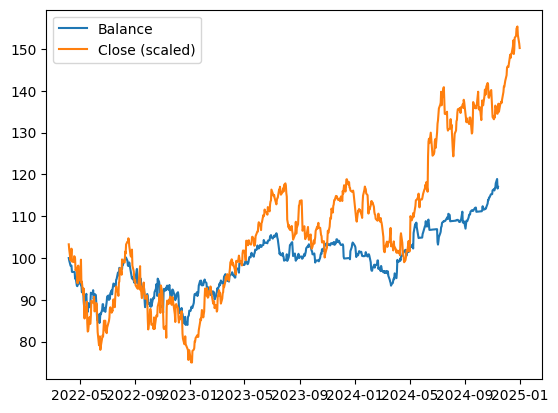

In [97]:
plt.plot(balances, label="Balance")
plt.plot(test_data["Close"] * 0.6, label="Close (scaled)")
plt.legend()
plt.show()